## Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/Drive")

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


## Links that you can refer to view documentation
* Keras Documentation : https://www.tensorflow.org/api_docs/python/tf/keras
* Numpy Documentation : https://numpy.org/doc/stable/reference/index.html#reference
* Matplotlib Pyplot Documentation : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
* Pickle Documentation : https://docs.python.org/3/library/pickle.html
* Original Link to Model Weights : https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
* Code Reference Taken From : https://www.kaggle.com/kissablemt/inceptionv3-fine-tuning-97
<br>
<br>

### A full End-to-End app is built using the Fine-Tuned InceptionV3 trainde model using Streamlit and hosted on streamlit.
#### Some Other Links
* GitHub Repo Link : https://github.com/DataRohit/Garbage-Image-Classification
* Web App Link : https://share.streamlit.io/datarohit/garbage-image-classification/streamlit-app/main.py
* Streamlit Docs : https://docs.streamlit.io/

# Imports

In [2]:
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Base Path for all files
data_dir = '/content/Drive/MyDrive/Garbage Classification/'

# Preparing Data

In [4]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir + "Images",
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir + "Images",
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# Building Model Using InceptionV3

## Initializing Base Model

In [5]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights(data_dir + 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

## Adding More Layers

In [6]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(6, activation='softmax') # 6 Output Neurons for 6 Classes
])

## Adam Optimizer

In [7]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [8]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,907,110
Trainable params: 2,104,326
Non-trainable params: 21,802,784
____________________________________

## Seperating Train and Test Data

In [9]:
# Setting variables for the model
batch_size = 64
epochs = 100

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 35
validation_steps : 3


## Using the ModelCheckpoint

In [11]:
# File Path to store the trained models
filepath = data_dir + "CNN-Models/model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]

## Training the Model

In [12]:
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.5595
Epoch 00001: val_accuracy improved from -inf to 0.72917, saving model to /content/Drive/MyDrive/Garbage Classification/CNN-Models/model_01-0.73.h5
35/35 [==============================] - 35s 783ms/step - loss: 1.2365 - accuracy: 0.5595 - val_loss: 0.8209 - val_accuracy: 0.7292
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.7661
Epoch 00002: val_accuracy improved from 0.72917 to 0.77083, saving model to /content/Drive/MyDrive/Garbage Classification/CNN-Models/model_02-0.77.h5
35/35 [==============================] - 27s 767ms/step - loss: 0.7081 - accuracy: 0.7661 - val_loss: 0.6325 - val_accuracy: 0.7708
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.8062
Epoch 00003: val_accuracy improved from 0.77083 to 0.84375, saving model to /content/Drive/MyDrive/Garbage Classification/CNN-Models/model_03-0.84.h5
35/3

## Plot final training metrics
Using Matplotlib to plot
* Model Accuracy vs Val-Accuracy
* Model Loss vs Val-Loss

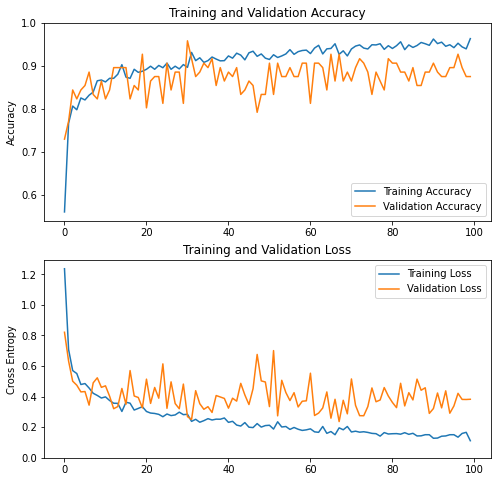

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Test the final model

In [14]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

8/8 [==============================] - 3s 419ms/step - loss: 0.4177 - accuracy: 0.8725
test accuracy :  0.8725099563598633


# Load the Model with Best Validation Accuracy

In [15]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model(data_dir + "CNN-Models/" + "model_31-0.96.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=12)
        plt.ylabel('Probability', fontsize=12)
        plt.xticks(index, classes, fontsize=12, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

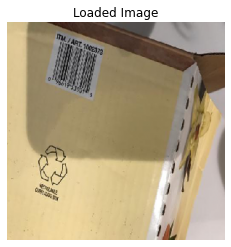



Maximum Probability:  0.66903186
Classified: cardboard 



-------------------Individual Probability--------------------------------

CARDBOARD : 66.9 %
GLASS : 0.04 %
METAL : 12.26 %
PAPER : 18.84 %
PLASTIC : 0.22 %
TRASH : 1.73 %


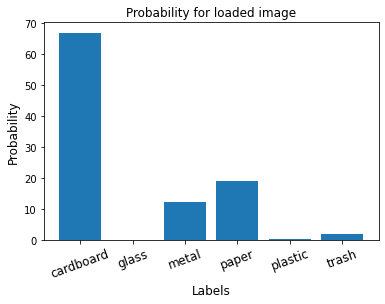

In [16]:
predict(data_dir + "Images/" + "cardboard/cardboard4.jpg")

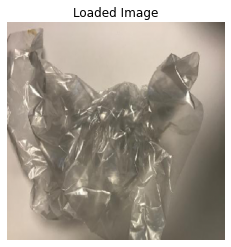



Maximum Probability:  0.932922
Classified: trash 



-------------------Individual Probability--------------------------------

CARDBOARD : 0.14 %
GLASS : 0.1 %
METAL : 4.44 %
PAPER : 1.36 %
PLASTIC : 0.66 %
TRASH : 93.29 %


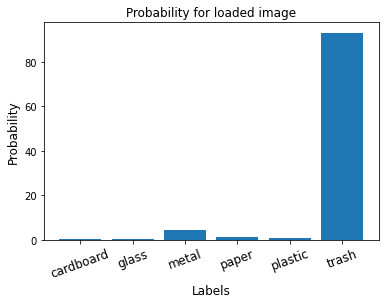

In [17]:
predict(data_dir + "Images/" + "trash/trash46.jpg")